# Experimental Design

In [76]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

warnings.filterwarnings('ignore')

Experimental design is the process in which we carry out research in an objective and controlled fashion. The purpose of this is to ensure we can make specific conclusions in reference to a hypothesis we have.

https://www.sciencedirect.com/topics/earth-and-planetary-sciences/experimental-design

Because we use objective tools, we need to use quantified language. Instead of using words like 'probably', 'likely', and 'small' when noting our conclusions, we should use precise and quantified language. This often takes the form of noting the percentage risk on a Type I error in the conclusion. 

Type I errors: we incorrectly reject the null hypothesis when it is actually true. 

## Terminology

Subjects
: What we are experimenting on

Treatment
: Some change given to one group

Control group
: The group not given any treatment

## How to assign subjects to groups

- Non Random (iloc with a range for instance)

In [ ]:
df = pd.read_feather('../data/dem_votes_potus_12_16.feather')

group1 = df.iloc[0:100]
group2 = df.iloc[100:200]


In [ ]:
group1.describe()

In [ ]:
group2.describe()

- Random (sample method for instance)

In [ ]:
random_group1 = df.sample(frac=0.5)
random_group1.describe()

In [ ]:
random_group2 = df.drop(random_group1.index)

In [ ]:
compare_df_rand = pd.concat([random_group1['dem_percent_12'].describe(), random_group2['dem_percent_12'].describe()], axis=1)
compare_df_rand.columns = ['group1', 'group2']

print(compare_df_rand)

# Experimental data setup

Randomization is often the best technique for setting up experimental data, but it isnt always.

## Scenarios where randomization could cause undesiderable outcomes

### Uneven issue

Different number of subjects in groups. Can be solved with block randomization.

### Covariates

Covariates are variables that potentially affect experiment results but aren't the primary focus. If covariates are highly variable or not equally distributed among groups, randomization might not produce balanced groups. This imbalance can lead to biased results. Overall these make it harder to see an effect from a treatment, as these issues may be driving an observed change.

In [ ]:
group1 = df.sample(frac=0.5, replace=False)
group1['Block']=1

group2 = df.drop(group1.index)
group2['Block']=2

print(len(group1), len(group2))

But does this technique eliminates the covariate issue?

A nice way of checking for potential covariate issues is with visualizations.

In [ ]:
sns.displot(data=df, x='dem_percent_12', fill=True, kind='kde'
            # , hue=''
           )

Not with this dataset, but it could happen that based on a second feature, thmere is quite a difference in the group distributions. When an effect could be because of a variable rather than the treatment, this is often called **confounding**. The covariate issue can be solved with stratified randomization.

### Stratified randomization

Stratified randomization involves splitting based on a potentially confounding variable first, followed by randomization


# Normal Data

Normal data is drawn from a normal distribution

The normal distribution is related to z-scores

$$z = \frac{ x - \mu}{ \sigma }$$

The most common normal distribution is the standard one, having $\mu$=0 and $\sigma$=0

The normal distribution is behind many of the statistical **parametric** tests. There are alse **non parametric** tests that dont assume normal data.

To visually check if a dataset follow a normal distribution we can plot the kde

Another visual tool are the qqplots, that compare 

In [ ]:
df = pd.read_csv('../data/chick_weight.csv')

df.info()

In [ ]:
n_rows=2
n_cols=2
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

for i, column in enumerate(df.columns):
    sns.distplot(df[column],ax=axes[i//n_cols,i%n_cols])


In [ ]:
qqplot(data=df.weight, line='s')
plt.show()

In [ ]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats.distributions import norm

qqplot(df['weight'], 
       line='s', 
       dist=norm
      ) 
plt.show()

In [ ]:
# Subset the data
subset_data = df[df['Time'] == 2]

# Repeat the plotting
sns.displot(data=df, x='weight', kind="kde")
plt.show()

- ideally, the dots should follow the line
- bad: bow out at the ends

Other tests for normality: 
- Shapiro-Wilk: good for smaller datasets
- D'Agostino $K^2$ (uses curtosis and skewness
- Anderson-Darling returns a list of values

For all these, the $H<sub>0</sub>$ is "data is drawn from a Normal distribution"

# A Shapiro Wilk test
from scipy.stats import shapiro

alpha = 0.05
stat, p = shapiro(df.weight)
print(f'p:{round(p,4)} test stat: {round(stat, 4)}')


In [ ]:
# A Anderson Darling test
from scipy.stats import anderson

alpha = 0.05
result = anderson(x = df.weight, dist="norm")
print(round(result.statistic,4))
print(result.significance_level)
print(result.critical_values)

# Factorial Design

Factorial designs study multiple independent variables/factors in one experiment

They test every combination of factor levels. It discovers direct effects and interactions between factors


In [54]:
marketing_data = pd.read_feather('../data/marketing_data.feather')

In [55]:
# Create a pivot table for marketing campaign data
marketing_pivot = marketing_data.pivot_table(
  values='Conversions', 
  index='Messaging_Style', 
  columns='Time_of_Day', 
  aggfunc='mean')

# View the pivoted results
print(marketing_pivot)

Time_of_Day         Evening     Morning
Messaging_Style                        
Casual           402.329004  401.133891
Formal           432.913043  411.096000


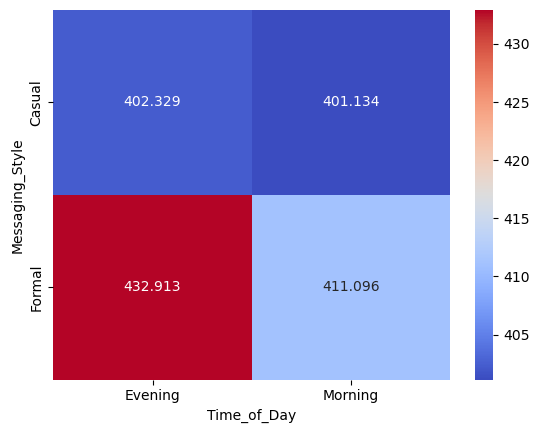

In [56]:
# Visualize interactions with a heatmap
sns.heatmap(marketing_pivot, 
         annot=True, 
         cmap='coolwarm',
         fmt='g')

plt.show()

The biggest change is registered in the evening messages from casual to formal.

### Factorial designs
- Multiple treatments and interactions
- Dissect complex multi variable effects and interactions
- Can require more subjects

### Block Designs
- Group similar subjects in randomized designs
- Control within-block variance
- Each treatment is tested within every block

# Randomized block design

Blocking involves grouping experimental units, often with similar characteristics, to minimize variance within these groups
Each block, representing a specific level of the blocking factor, receives every treatment. 

In [61]:
athletes = pd.read_csv('../data/athletic_perf.csv')
athletes

,Athlete_ID,Training_Program,Diet_Type,Initial_Fitness,Performance_Inc
0,1,Strength,Keto,Low,8.749524
1,2,HIIT,Plant-Based,High,9.452781
2,3,Strength,Plant-Based,Low,13.928506
3,4,Strength,Plant-Based,High,9.605557
4,5,HIIT,Plant-Based,Low,7.547894
...,...,...,...,...,...
295,296,Endurance,Plant-Based,Medium,9.438768
296,297,Endurance,Keto,Low,10.749170
297,298,Endurance,Plant-Based,Medium,7.902343
298,299,Endurance,Keto,Medium,5.761285


To implement a randomized block design, we'll group the rows into blocks based on an initial feature, shuffle the rows within these blocks, and randomly assign a treatment.

In [63]:
blocks = athletes.groupby('Initial_Fitness').apply(
    # Lets shuffle each block
    lambda x:x.sample(frac=1)
)
blocks = blocks.reset_index(drop=True)
blocks

,Athlete_ID,Training_Program,Diet_Type,Initial_Fitness,Performance_Inc
0,18,Endurance,High-Protein,High,11.302130
1,264,Strength,Keto,High,9.993298
2,9,Strength,Keto,High,11.599382
3,199,Endurance,High-Protein,High,8.872467
4,151,Endurance,Plant-Based,High,7.530111
...,...,...,...,...,...
295,210,HIIT,Plant-Based,Medium,5.651353
296,7,Strength,Plant-Based,Medium,10.356257
297,230,Strength,Plant-Based,Medium,11.916508
298,286,Strength,Plant-Based,Medium,10.864617


In [65]:
# Now, within each block, we assign exercise program randomly
blocks['Treatment'] = np.random.choice(
    ['Cardio', 'Strength Training', 'Mixed'], 
    size=len(blocks)
)

blocks.head()

,Athlete_ID,Training_Program,Diet_Type,Initial_Fitness,Performance_Inc,Treatment
0,18,Endurance,High-Protein,High,11.302130,Cardio
1,264,Strength,Keto,High,9.993298,Mixed
2,9,Strength,Keto,High,11.599382,Mixed
3,199,Endurance,High-Protein,High,8.872467,Strength Training
4,151,Endurance,Plant-Based,High,7.530111,Strength Training


<Axes: xlabel='Initial_Fitness', ylabel='Performance_Inc'>

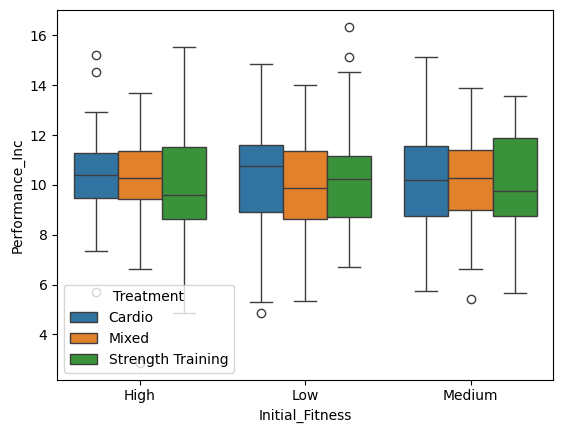

In [67]:
# A boxplot is an effective tool for visualizing the distribution of treatment effects across different blocks 

sns.boxplot(x='Initial_Fitness', y='Performance_Inc', hue='Treatment', data=blocks)

We can use ANOVA to statistically check for these differences.

In [69]:
alpha=0.05

from scipy.stats import f_oneway

blocks.groupby("Initial_Fitness").apply(
    lambda x: f_oneway(x[x['Treatment']== 'Cardio']['Performance_Inc'],
                       x[x['Treatment']== 'Mixed']['Performance_Inc'], 
                       x[x['Treatment']== 'Strength Training']['Performance_Inc'], 
                      )
)

Initial_Fitness
High        (0.3991565409997103, 0.6721365414897893)
Low         (0.4299987443000486, 0.6515985972727005)
Medium    (0.026995319447116313, 0.9733731835966434)
dtype: object

# Covariate adjustment in experimental design

Covariates are variables that are not of primary interest but are related to the outcome variable and can influence its analysis. Including covariates in statistical analyses is crucial for reducing confounding, which occurs when an external variable influences both the dependent variable and independent variable(s).

By adjusting for covariates researchers can isolate the effect of the independent variable on the outcome, minimizing the influence of confounders.

Like that, the analysis better reflects the true effect by isolating it from the influence of covariates.



In [72]:
exp_chick_data = pd.read_csv('../data/chick_weight.csv')
cov_chick_data = pd.read_csv('../data/chick_cov.csv')


In [73]:
exp_chick_data

,weight,Time,Chick,Diet
0,42,0,1,1
1,51,2,1,1
2,59,4,1,1
3,64,6,1,1
4,76,8,1,1
...,...,...,...,...
573,175,14,50,4
574,205,16,50,4
575,234,18,50,4
576,264,20,50,4


In [78]:
# Perform ANCOVA with Diet and Time as predictors
model = ols('weight ~ Diet + Time', data=exp_chick_data).fit()

# Print a summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     809.2
Date:                Sun, 04 Aug 2024   Prob (F-statistic):          6.77e-168
Time:                        18:02:55   Log-Likelihood:                -2897.1
No. Observations:                 578   AIC:                             5800.
Df Residuals:                     575   BIC:                             5813.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5428      4.043      0.382      0.7

Prob (F-statistic): The first portion of summary output provides details on the significance of the model; it shows a very small p-value, supporting for covariates affecting the model.
Large p-values would implie a lack of support for covariates affecting the model.

P>|t| of the second portion are very small, sugesting that each of them alone are significant predictors of growth for this model.

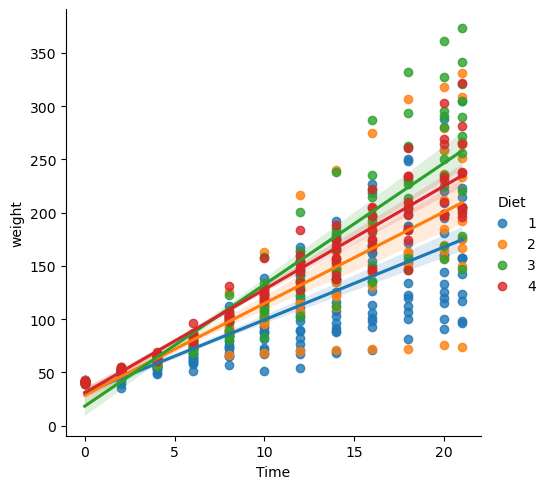

In [80]:
# Visualize Diet effects with Time adjustment
sns.lmplot(x='Time', y='weight', 
         hue='Diet', 
         data=exp_chick_data)
plt.show()

The crossing lines here suggest we may add a The crossing regression lines suggest we may want to add an interaction term of time by Diet in another model. Parallel lines would suggest a lack of interaction.